# Data loading and processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import f_regression
%matplotlib inline

In [2]:
#Loading train and test data (test set for competition will be called evaluate)
data = pd.read_csv('train.csv', index_col = 'Id')
evaluate = pd.read_csv('test.csv', index_col = 'Id')

In [3]:
#appending both sets to be sure, that made changes whould be the same
full = data.append(evaluate, ignore_index=False, sort = False)

## Features engineering

In [4]:
#creating three typeas of variables: qualitive (only for factorization), 
#ordinal (to change names so that bigger number is better) and quantitive (no need for change)
qualitive = ['MSSubClass', 'MSZoning', 'BldgType', 'Heating',
             'GarageType', 'GarageFinish', 
                 'SaleType', 'SaleCondition',
                'Foundation', 'Fence']

ordinal = ['Street', 'LotShape', 'Basement', 'AfterRemod', 'Utilities', 'LandSlope', 'KitchenQual', 'PavedDrive', 
                'CentralAir']
    
quantitive = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'GarageArea']

In [6]:
for i in qualitive:
    full[i] = full[i].factorize()[0]

In [7]:
full['Basement'] = full['BsmtQual'].notnull().map({True: 1, False: 0})

In [8]:
full['AfterRemod'] = full['YearBuilt'].where(full['YearBuilt'] == full['YearRemodAdd']).isna().map({True: 1, False: 0})

In [9]:
full['GarageArea'] = full['GarageArea'].fillna(0)

In [10]:
full['KitchenQual'] = full['KitchenQual'].map({'Fa': 0,
                    'TA': 1, 
                    'Gd': 2, 
                    'Ex': 3})
full['KitchenQual'] = full['KitchenQual'].fillna(0)

In [11]:
full['Street'] = full['Street'].map({'Grvl': 0,
                    'Pave': 1})

In [12]:
full['LotShape'] = full['LotShape'].map({'IR3': 0,
                    'IR2': 1, 
                    'IR1': 2, 
                    'Reg': 3})

In [13]:
full['Utilities'] = full['Utilities'].map({'AllPub': 1,
                    'NoSeWa': 0})
full['Utilities'] = full['Utilities'].fillna(0)

In [14]:
full['LandSlope'] = full['LandSlope'].map({'Sev': 0,
                    'Mod': 1, 
                    'Gtl': 2})

In [15]:
full['PavedDrive'] = full['PavedDrive'].map({'N': 0,
                    'P': 1, 
                    'Y': 2})

In [16]:
full['CentralAir'] = full['CentralAir'].map({'N': 0,
                    'Y': 1})

## Sets

In [17]:
#joining all needen columns in one DataFrame
full = full[qualitive].join(full[quantitive]).join(full[ordinal]).join(full['SalePrice'])

In [18]:
#division of trainging and evaluate sets
data = full[full['SalePrice'].isna() == False]
evaluate = full[full['SalePrice'].isna() == True].drop(labels = 'SalePrice', axis = 1)

In [19]:
#creating X and y sets
y = data['SalePrice']
X = data.drop(labels = 'SalePrice', axis = 1)

In [20]:
#division of sets for training and scoring
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Decision Tree model learning

In [21]:
#training Decision Tree without limits for hiperparameters
tree = DecisionTreeRegressor(random_state = 1)
tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [22]:
#checking a score (low - probably overfitted model)
tree_score = tree.score(X_test, y_test)
tree_score 

0.5697202187903585

In [23]:
#exporting tree to external file for visualisation
export_graphviz(tree, out_file='graph')

# Chossing best hiperparameters with GridSearchCV

In [24]:
#using GridSearchCV module to find best hiperparameters for Decision Tree with usage of Cross Validation
estimator = DecisionTreeRegressor(random_state = 1)
param_grid = {'max_depth': range(1, 5),
              'min_samples_leaf': range (1, 10),
             'min_samples_split': range (2, 10)}
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, n_jobs=4)
grid.fit(X=X, y=y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(1, 5), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
#checking the best hiperparameters
best_params = pd.Series(grid.best_params_)
best_params

max_depth            4
min_samples_leaf     7
min_samples_split    2
dtype: int64

In [26]:
#model scoring - much better than tree without limits
grid_score = grid.score(X=X_test, y=y_test)
grid_score

0.7893172138113573

# Random forest training

In [27]:
#Random Forest training using the best hiperparameters
sqrt = int(np.sqrt(len(X_train.columns)))
forest = RandomForestRegressor(max_depth=best_params['max_depth'],
                              min_samples_leaf = best_params['min_samples_leaf'],
                              min_samples_split = best_params['min_samples_split'], n_estimators=20, random_state = 1,
                              bootstrap=True, max_features=sqrt, n_jobs=4)
forest.fit(X=X_train, y=y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=4, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [28]:
forest_score = forest.score(X=X_test, y=y_test)
forest_score

0.7186492950366237

In [29]:
#checking importance of used variables
feature_importances = pd.Series(forest.feature_importances_, X_train.columns).sort_values(ascending=False)
feature_importances

OverallQual      0.382883
YearBuilt        0.125822
GarageArea       0.099993
Foundation       0.099049
KitchenQual      0.087891
LotArea          0.080121
GarageFinish     0.042999
SaleType         0.016718
LotShape         0.015757
MSSubClass       0.013342
SaleCondition    0.008876
GarageType       0.004862
CentralAir       0.004170
Fence            0.003990
AfterRemod       0.003844
BldgType         0.003443
MSZoning         0.003217
OverallCond      0.001663
LandSlope        0.001360
Street           0.000000
PavedDrive       0.000000
Basement         0.000000
Utilities        0.000000
Heating          0.000000
dtype: float64

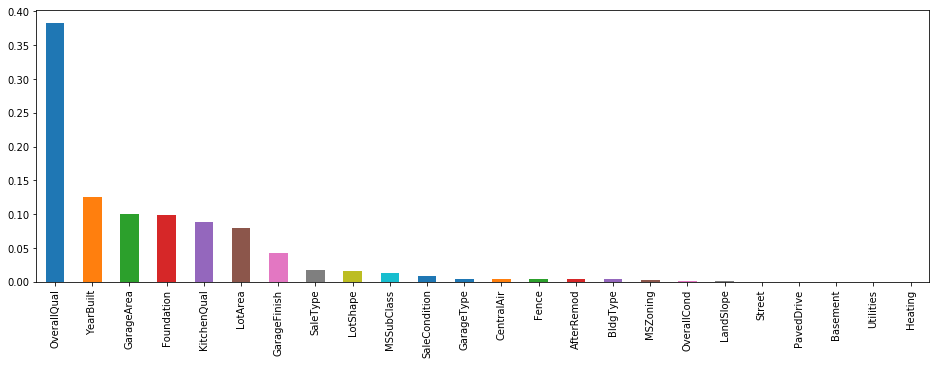

In [30]:
feature_importances.plot(kind = 'bar', figsize=(16, 5))

## Least square regression

In [31]:
#preparing datasets for Linear Regression (only ordinal and quantitive data)
X_train_lin = X_train[quantitive].join(X_train[ordinal])
X_test_lin = X_test[quantitive].join(X_test[ordinal])

In [46]:
#Linear Regression using Least Square Method
square = LinearRegression(fit_intercept=False, copy_X=True, n_jobs = 4)
square.fit(X_train_lin,y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=4, normalize=False)

In [47]:
square_score = square.score(X_test_lin,y_test)
square_score

0.734137839171173

In [34]:
#checking coefficients
square.intercept_

-619141.69130216

In [35]:
pd.Series(square.coef_, X_train_lin.columns)

LotArea            1.072300
OverallQual    28388.589603
OverallCond     1529.825026
YearBuilt        243.433576
GarageArea        80.067367
Street         38276.734758
LotShape       -7275.871142
Basement       -1074.826863
AfterRemod     12549.082880
Utilities      52643.350390
LandSlope      -6300.605847
KitchenQual    18118.714013
PavedDrive      -136.277720
CentralAir     -2975.239139
dtype: float64

## Lasso Regression

In [77]:
#Linear Regression using Lasso Method
lasso = Lasso(fit_intercept=False, copy_X=True, random_state=1, max_iter=10000, alpha=1)
lasso.fit(X=X_train_lin, y=y_train)

C:\Users\Mateusz Bujalski\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [78]:
lasso_score = lasso.score(X=X_test_lin, y=y_test)
lasso_score

0.7341012370119773

## DummyRegressor

In [38]:
#comparing obtained scores with score from Dummy Regressor
dummy = DummyRegressor(strategy='mean')
dummy.fit(X=X_train, y=y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [39]:
dummy.score(X = X_test, y=y_test)

-0.005807477762133084

## Predictions for test data

In [40]:
scores = pd.Series({'tree': tree_score,
'grid': grid_score,
'forest': forest_score,
'square': square_score,
'lasso': lasso_score})
scores.sort_values(ascending = False)

grid      0.789317
square    0.731003
lasso     0.730978
forest    0.718649
tree      0.569720
dtype: float64

In [41]:
scores.idxmax()

'grid'

In [42]:
#creating file for submission using model with the best score
predict = grid.predict(X = evaluate)

In [43]:
results = pd.DataFrame({'Id': evaluate.index,
                        'SalePrice': predict})

In [44]:
results = results.set_index(keys = 'Id')

In [45]:
results.to_csv('submission.csv')